# ДЗ-2 по Теории и практике онлайн экспериментов


Данные лежат на диске: https://disk.yandex.ru/d/9EcCqk-1CUyiCA

### Задание 1 (3 балла)

Представим, что у нас есть сервис для продажи некоторых товаров (например, мыла). Мы выкатываем новые фичи и проводим тесты, а затем сохраняем логи каждого теста в следующем формате:

- `user_id` - уникальный id посетителя сайта
- `dt` - дата события
- `event` - название события
- `group` - группа, в которую попал пользователь (распределение может происходить на разных этапах воронки для разных тестов - например, при первом посещении или при первом добавлении в корзину)
- `visit_id` - уникальный id визита
- `cart_id` - уникальный id корзины
- amount - текущая сумма корзины
- `num_items` - текущее количество товаров в корзине


1. Обратимся к метрике **average revenue per paying user**. Вам даны две очень похожие группы (файл `aa_test_logs.pkl`). 

- Постройте распределение p-value для теста на равенство средних между группами.
- Найдите, на каком уровне искусственно добавленного эффекта средняя выручка в группах станет различима. Ошибку первого рода считайте заданной и равной 0.05, ошибку 2-го рода равной 0.2.

2. На данных `aa_test_logs.pkl` сравните мощность линеаризации, бутстрапа, бакетизации и дельта-метода для метрики **среднего чека**. Какой метод получился наиболее мощным? Как вы думаете, почему?

3. Мы сделали рекомендательную систему, которая после добавления товара в корзину предлагает добавить похожие или комплементарные. Логи проведенного теста сохранены в файле `ab_test_logs.pkl`. 

- Проверьте гипотезу о том, что это изменение значимо повлияло на ARPPU наших power users (95%-й процентиль).
- Проверьте гипотезу о том, что это изменение значимо повлияло на ARPPU всех юзеров.

### Задание 2 (1 балл)

В приложенном файле `sleep.csv` приведено время засыпания одного и того же человека в разные дни.

Нужно обработать эти данные и указать такое время суток (с точностью до минуты), после которого с вероятностью 0.9 этот человек уже спит.

Как можно оценить стандартное отклонение этой точечной оценки?

### Задание 3. CUPED (2 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [3]:
control_before = stats.expon(scale=1000).rvs(1000)

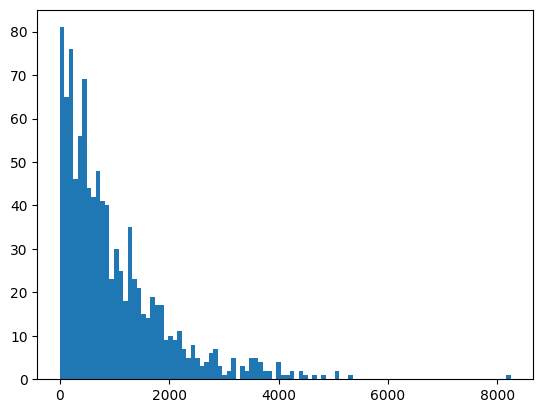

In [4]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [5]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

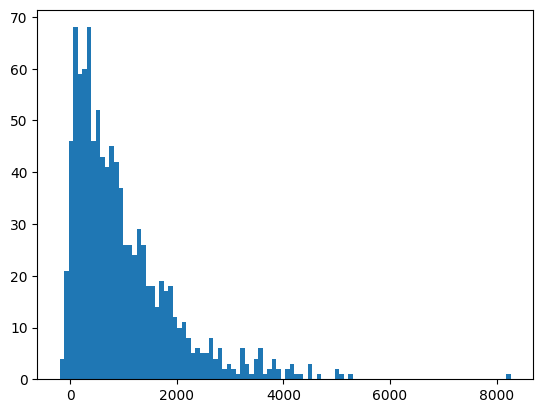

In [6]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [7]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([ 924.29770981, 1043.6677036 ])

In [10]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:07<00:00, 1355.59it/s]

Стат значимая разница есть в 5.2% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    mean = ...
    std = ...
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )

    control_cup_a = ...
    control_cup_b = ...

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:



Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [ ]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
for i in tqdm(range(N)):
    control_before_full = sps.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=10, scale=100).rvs(
        samples_in_ab // 2
    )

    control_cup_a = ...
    control_cup_b = ...

    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt += 1

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1

print(
    f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев"
)

### Задание 4. Методы снижения дисперсии (2 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи: 
- `None` - пользователь не участвует в АБ тесте, 
- `*_before_i` - соответствующая группа до начала теста, 
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение. 

Cчитайте, что юзеры всегда идут в одном порядке в группах. То есть `data[data.group == 'control_before_i']`
дает юзеров в той же последовательности, что `data[data.group == 'control_after_i']` для всех i.  Аналогичное верно для тритмента.


#### Что надо сделать:
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED. 

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [ ]:
data = pd.read_csv("data_ab.csv")

In [ ]:
data.head()

,age,metric,group
0,young,11309.036916,treatment_before
1,young,8496.554679,control_before
2,young,11891.862586,control_before
3,young,9229.445011,treatment_before
4,young,10410.961279,control_before


### Задание 5. Линеаризация + CUPED (2.5 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метрик.